In [1]:
from unlabeled_extrapolation.models import bit_resnet, vit_model, timm_model, clip_model
from unlabeled_extrapolation.utils import utils
import importlib
import timm
import torch
from torch import nn
import numpy as np
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
ue_src = '/u/scr/ananya/cifar_experiments/transfer_learning/unlabeled_extrapolation'
if ue_src not in sys.path:
    sys.path = [ue_src] + sys.path
print(sys.path)

['/u/scr/ananya/cifar_experiments/transfer_learning/unlabeled_extrapolation', '/juice/scr/ananya/cifar_experiments/transfer_learning/scripts', '/juice/scr/ananya/cifar_experiments/transfer_learning/scripts', '/u/nlp/anaconda/main/anaconda3/envs/ananya-ue/lib/python38.zip', '/u/nlp/anaconda/main/anaconda3/envs/ananya-ue/lib/python3.8', '/u/nlp/anaconda/main/anaconda3/envs/ananya-ue/lib/python3.8/lib-dynload', '', '/sailhome/ananya/.local/lib/python3.8/site-packages', '/u/nlp/anaconda/main/anaconda3/envs/ananya-ue/lib/python3.8/site-packages', '/u/nlp/anaconda/main/anaconda3/envs/ananya-ue/lib/python3.8/site-packages/apex-0.1-py3.8-linux-x86_64.egg', '/juice/scr/ananya/cifar_experiments/wilds', '/juice/scr/ananya/cifar_experiments/transfer_learning', '/juice/scr/ananya/verified_calibration', '/u/nlp/anaconda/main/anaconda3/envs/ananya-ue/lib/python3.8/site-packages/IPython/extensions', '/sailhome/ananya/.ipython']


In [3]:
from datasets import breeds

In [4]:
datasets = ['living17_nonorm', 'waterbirds', 'domainnet']
models = ['clip_vit_b16', 'clip_vit_l14', 'timm_vit_b16_in21k', 'dino_vit_b16', 'convnext_vit_b', 'bit_resnet_50_in21k', 'bit_resnet_101_in21k']
model_display_names = ['clip_b', 'clip_l', 'vit_b', 'dino_b', 'convnext_b', 'resnet50', 'resnet101']
log_root = '../logs/'

def get_gradient_log_name(dataset_name, model_name):
    return f'full_ft_epochs1_no_train__{dataset_name}_{model_name}'

def get_dir_path(dataset_name, model_name):
    log_name = get_gradient_log_name(dataset_name, model_name)
    run_name = 'epochs-1_no_train-True_optimizer.args.lr-0.0_scheduler.args.T_max-1_seed-0_run0'
    return log_root + '/' + log_name + '/' + run_name + '/'

def get_config_path(dir_path):
    return dir_path + '/config.json'

def get_stats_path(dir_path):
    return dir_path + '/stats.tsv'

def get_random_images(dataset, n=100):
    indices = np.random.choice(np.arange(len(dataset)), size=n, replace=False)
    return [dataset[i][0].cpu().detach().numpy() for i in indices]

In [5]:
S = {'grad_1', 'grad_2', 'norm_1', 'other'}
filtered_S = [s for s in S if 'grad' in s]
print(filtered_S)

['grad_2', 'grad_1']


living17_nonorm


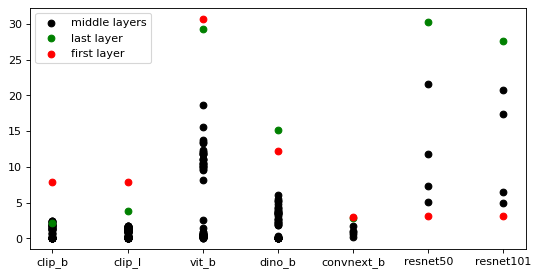

waterbirds


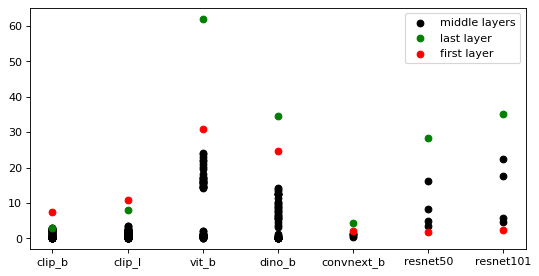

domainnet


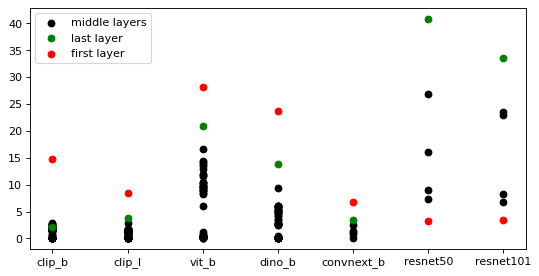

In [7]:
def filter_df_get_grad(df):
    filtered_keys = [s for s in list(df.keys()) if 'grad' in s and '_grad' not in s]
    df = df[filtered_keys]
    return df.to_dict(orient='records')[0]

def filter_df_get_norm(df):
    filtered_keys = [s for s in list(df.keys()) if 'norm_' in s]
    df = df[filtered_keys]
    return df.to_dict(orient='records')[0]

def filter_df_get_normalized_grad(df):
    filtered_keys = [s for s in list(df.keys()) if 'grad' in s and '_grad' not in s]
    norm_keys = [s for s in list(df.keys()) if 'norm_' in s]
    filtered_d = df[filtered_keys].to_dict(orient='records')[0]
    norm_d = df[norm_keys].to_dict(orient='records')[0]
    normalized_grad_d = {}
    for fk, nk in zip(filtered_keys, norm_keys):
        normalized_grad_d[fk] = filtered_d[fk] / norm_d[nk]
    return normalized_grad_d

# def filter_df_get_norm_grad(df):
#     filtered_keys = [s for s in list(df.keys()) if 'param_normalized_grad' in s]
#     print(filtered_keys)
#     return df[filtered_keys]   

def get_dataset_grad_stats(datasets, models, model_display_names, filter_df):
    dataset_stats = {}
    for dataset in datasets:
        print(dataset)
        figure(figsize=(8, 4), dpi=80)
        for model_idx, model in enumerate(models):
            dir_path = get_dir_path(dataset, model)
            config_path = get_config_path(dir_path)
            stats_path = get_stats_path(dir_path)
            with open(config_path, 'r') as f:
                config = json.load(f)
            train_data = utils.init_dataset(config['train_dataset'])
            if model_idx == 1:
                random_images = get_random_images(train_data,n=10)
                dataset_stats[dataset] = {
                    'mean': np.mean(random_images),
                    'std': np.mean(np.std(random_images, axis=(1,2,3))),
                    'std_mean': np.std(np.mean(random_images, axis=(1,2,3)))
                }
            df = pd.read_csv(stats_path, sep='\t')
            d = filter_df(df)
            values = list(d.values())
            if model_idx == 1:
                plt.scatter([model_idx]*(len(d)-2), values[1:-1], c='black', label='middle layers')
                plt.scatter([model_idx], values[-1], c='green', label='last layer')
                plt.scatter([model_idx], values[0], c='red', label='first layer')
            else:
                plt.scatter([model_idx]*(len(d)-2), values[1:-1], c='black')
                plt.scatter([model_idx], values[-1], c='green')
                plt.scatter([model_idx], values[0], c='red')
        my_xticks = ['John','Arnold','Mavis','Matt']
        plt.legend()
        plt.xticks(list(range(len(model_display_names))), model_display_names)

        plt.show()
#         print(d.values())
#             print(filtered_keys)
#             print(df['train/grad_patch_embed'])
#             print(df[filtered_keys])
#             print(df[compute_keys(df)])
    return dataset_stats

dataset_stats = get_dataset_grad_stats(datasets, models, model_display_names, filter_df_get_grad)
# dataset_stats = get_dataset_grad_stats(datasets, models, model_display_names, filter_df_get_normalized_grad)
# dataset_stats = get_dataset_grad_stats(datasets, models, model_display_names, filter_df_get_norm)


In [50]:
print(dataset_stats)
# The std-devs within the image, and the std devs of the mean, are pretty similar (and small).
# So it's really the mean that varies a lot.
# I think the "obvious" thing to do is to normalize the images to have the same mean, std-dev
# Let's check this and see what the gradients look like if we do this.

{'living17_nonorm': {'mean': 0.405586, 'std': 0.19588944, 'std_mean': 0.105948165}, 'waterbirds': {'mean': 0.37670943, 'std': 0.22946799, 'std_mean': 0.11904866}, 'domainnet': {'mean': 0.8599936, 'std': 0.1735559, 'std_mean': 0.15381968}}


In [ ]:
# Loop over datasets
    # Loop over models
        # Get folder name
        # Get gradient stats
        # Compute relevant stats. E.g., for transformer models combine blocks?
        # Plot stats. Can start by just plotting first layer and some in between layer for every model?
    # For the first model, load config. Load dataset.
    # Sample random images. Get image mean. Std-dev within a single image. Variance of the mean across images.